In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tf_mcc import MCC

In [4]:
# load training and validation sets

X_train = pd.read_csv("dataset/X_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
y_train = pd.read_csv("dataset/y_train.csv")
y_val = pd.read_csv("dataset/y_val.csv")

# load test set
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv")

In [5]:
X_train = X_train['title'].values
X_val = X_val['title'].values
X_test = X_test['title'].values

y_train = y_train['classification'].values
y_val = y_val['classification'].values
y_test = y_test['classification'].values

In [7]:
# model parameters
vocabulary_size = 10000 # maximum vocabulary size (max_features, maximum number of tokens)
max_len = 250 # sequence length to pad the outputs to
embedding_dim = 16

# create vocab layer
# instantiate the text vectorization layer
vectorize_layer = TextVectorization(max_tokens = vocabulary_size, 
                                    standardize = "lower_and_strip_punctuation", 
                                    output_mode = "int", 
                                    output_sequence_length = max_len)

# build the vocabulary
# vectorization layer that generates a tensor of shape (batch_size, max_len) containing vocabulary indices
vectorize_layer.adapt(X_train)

# vectorize_layer.get_vocabulary()
# vectorize_layer.vocabulary_size()

In [8]:
train_text = vectorize_layer(X_train)
val_text = vectorize_layer(X_val)
test_text = vectorize_layer(X_test)

In [11]:
# train_text.shape

In [12]:
model = Sequential([
    tf.keras.Input(shape = (250,), dtype = tf.int64),
    layers.Embedding(vocabulary_size + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units = 1, activation = "sigmoid") # revise the use of this layer
]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### train the model

In [15]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  MCC(),
              ],
)


early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, 
                                              restore_best_weights = True)



history = model.fit(
        train_text, y_train,
        validation_data = (val_text, y_val),
        epochs = 20,
        callbacks = [early_stop],
)

Epoch 1/20
831/831 [==============================] - 6s 5ms/step - loss: 0.6764 - binary_accuracy: 0.6144 - precision_1: 0.7382 - recall_1: 0.3081 - mcc: 0.2578 - val_loss: 0.6390 - val_binary_accuracy: 0.8994 - val_precision_1: 0.8589 - val_recall_1: 0.9526 - val_mcc: 0.8036
Epoch 2/20
831/831 [==============================] - 4s 4ms/step - loss: 0.5733 - binary_accuracy: 0.8804 - precision_1: 0.8955 - recall_1: 0.8508 - mcc: 0.7610 - val_loss: 0.4963 - val_binary_accuracy: 0.9108 - val_precision_1: 0.9151 - val_recall_1: 0.9030 - val_mcc: 0.8216
Epoch 3/20
831/831 [==============================] - 4s 4ms/step - loss: 0.4359 - binary_accuracy: 0.9131 - precision_1: 0.8958 - recall_1: 0.9273 - mcc: 0.8266 - val_loss: 0.3787 - val_binary_accuracy: 0.9117 - val_precision_1: 0.9340 - val_recall_1: 0.8835 - val_mcc: 0.8244
Epoch 4/20
831/831 [==============================] - 4s 4ms/step - loss: 0.3349 - binary_accuracy: 0.9220 - precision_1: 0.9028 - recall_1: 0.9390 - mcc: 0.8446 - va

### save vectorizer and model

In [30]:
# instantiate keras tensor stating the shape and type of the input
text_input = tf.keras.Input(shape = (1,), dtype = tf.string, name = "text_input")
vectorized = vectorize_layer(text_input)


output = model(vectorized)

full_model = tf.keras.Model(text_input, output)

full_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  MCC(),
              ],
)


In [23]:
full_model(X_train[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[9.9427557e-01],
       [5.8742791e-01],
       [9.0090853e-01],
       [9.9997932e-01],
       [3.8897560e-04]], dtype=float32)>

In [31]:
full_model.save("model/fake_news_classifier")

INFO:tensorflow:Assets written to: model/fake_news_classifier/assets


INFO:tensorflow:Assets written to: model/fake_news_classifier/assets


In [17]:
history.history

{'loss': [0.6764113903045654,
  0.573337733745575,
  0.4358932673931122,
  0.33490628004074097,
  0.2702355682849884,
  0.22672930359840393,
  0.1949721872806549,
  0.17220208048820496,
  0.1551186442375183,
  0.1410752534866333,
  0.12862683832645416,
  0.11973682790994644,
  0.11146562546491623,
  0.10537075251340866,
  0.09897641837596893,
  0.09382619708776474,
  0.08916448801755905,
  0.08439692109823227,
  0.08057084679603577,
  0.07707232981920242],
 'binary_accuracy': [0.6143739223480225,
  0.8804306983947754,
  0.91307133436203,
  0.9219561815261841,
  0.9305022358894348,
  0.9365634918212891,
  0.9430012702941895,
  0.9480084180831909,
  0.9519614577293396,
  0.9550108909606934,
  0.9577968716621399,
  0.9595286250114441,
  0.962954580783844,
  0.9635946154594421,
  0.9662675857543945,
  0.9683758616447449,
  0.969279408454895,
  0.9712371230125427,
  0.9721406698226929,
  0.9730818271636963],
 'precision_1': [0.7381933927536011,
  0.8955297470092773,
  0.8957986831665039,
  

### performance of the training and validation sets

In [25]:
epochs = history.epoch

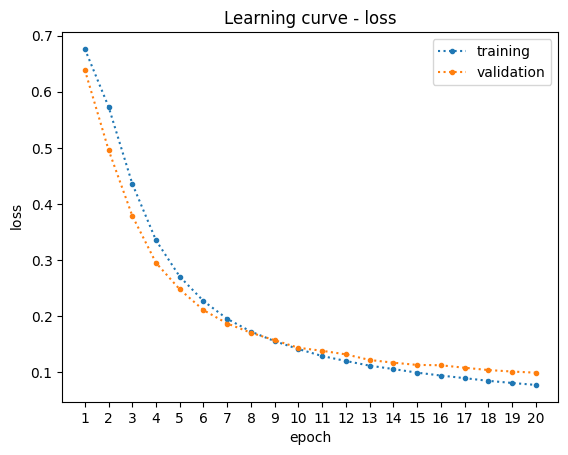

In [27]:
plt.plot(range(1, max(epochs) + 2), history.history['loss'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_loss'], ".:")

plt.title('Learning curve - loss')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel(r"$\mathrm{loss}$")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

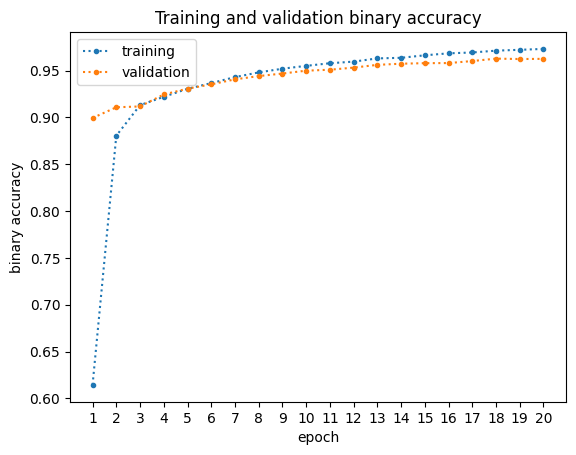

In [28]:
plt.plot(range(1, max(epochs) + 2), history.history['binary_accuracy'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_binary_accuracy'], ".:")

plt.title('Training and validation binary accuracy')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("binary accuracy")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

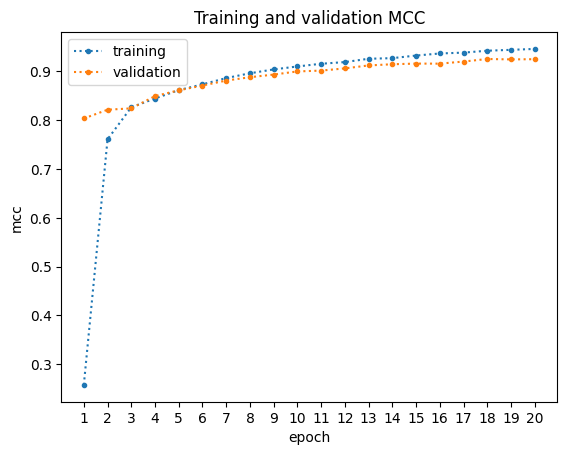

In [29]:
plt.plot(range(1, max(epochs) + 2), history.history['mcc'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_mcc'], ".:")

plt.title('Training and validation MCC')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("mcc")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

###### model performance on the test set

In [19]:
y_pred = model.predict(test_text)

277/277 [==============================] - 0s 1ms/step


In [20]:
y_pred.shape

(8855, 1)

In [21]:
y_pred > 0.5

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [22]:
evaluation = model.evaluate(x = test_text, y = y_test, return_dict = True)

277/277 [==============================] - 0s 1ms/step - loss: 0.0999 - binary_accuracy: 0.9641 - precision: 0.9614 - recall: 0.9641 - mcc: 0.9281


In [23]:
evaluation.items()

dict_items([('loss', 0.09994752705097198), ('binary_accuracy', 0.9640880823135376), ('precision', 0.9613854289054871), ('recall', 0.9640929102897644), ('mcc', 0.9280852675437927)])

In [24]:
for metric, value in evaluation.items():
    print(f"{metric}: {value:.4f}")

loss: 0.0999
binary_accuracy: 0.9641
precision: 0.9614
recall: 0.9641
mcc: 0.9281
